# Нейронные сети: Autograd

## Библиотеки

In [24]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import expit
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid


from torchvision import datasets
from torchvision import transforms

## Разбор домашней задачи

Рассмотрим совместное правдоподобие модели и данных:
$$
p\bigr(\mathbf{y}, \mathbf{w}|\mathbf{X}\bigr) = \prod_{i=1}^{l}p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr)p\bigr(\mathbf{w}\bigr),
$$
где для для простоты рассмотрим $p\bigr(\mathbf{w}\bigr)=\mathcal{N}\bigr(\mathbf{0}, \gamma\mathbf{I})$.

По принципу максимума правдоподобия получаем следующую функцию для минимизации:
$$
\mathcal{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = -\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) - \log p\bigr(\mathbf{w}\bigr) = \sum_{i=1}^{l}\left[\frac{\beta}{2}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i-y_i\right)^2 + C_1\right] + \frac{\gamma}{2}\mathbf{w}^{\mathsf{T}}\mathbf{w} + C_2.
$$
Для удобства перепишем в матричном виде:
$$
\beta\sum_{i=1}^{l}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i - y_i\right)^2 + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}=
\beta\left(\mathbf{X}\mathbf{w} - \mathbf{y}\right)^{\mathsf{T}}\left(\mathbf{X}\mathbf{w} - \mathbf{y}\right)  + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}= 
\beta\mathbf{w}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\beta\mathbf{y}\mathbf{X}\mathbf{w} + \beta\mathbf{y}^{\mathsf{T}}\mathbf{y} + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}
$$

Воспользуемся необходимым условием первого порядка:
$$
\frac{\partial}{\partial \mathbf{w}}\left(\beta\mathbf{w}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\beta\mathbf{y}\mathbf{X}\mathbf{w} + \beta\mathbf{y}^{\mathsf{T}}\mathbf{y} + \gamma\mathbf{w}^{\mathsf{T}}\mathbf{w}\right) = 0 = 2\beta\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\beta\mathbf{X}^{\mathsf{T}}\mathbf{y} + 2\gamma\mathbf{w} \Rightarrow \hat{\mathbf{w}} = \beta\left(\beta\mathbf{X}^{\mathsf{T}}\mathbf{X} + \gamma\mathbf{I}\right)^{-1}\mathbf{X}^{\mathsf{T}}\mathbf{y}
$$

In [25]:
np.random.seed(0)
l = 1000
n = 2


X_train = np.random.randn(l, n)
X_test = np.random.randn(500, n)
w = np.random.randn(n)
Y_train = np.random.binomial(n=1, p=expit(X_train@w))
Y_test = np.random.binomial(n=1, p=expit(X_test@w))

In [26]:
loo = KFold(10)
number_of_batch = loo.get_n_splits(X_train)

gamma_scores = dict()
gammas = [1e-10, 1e-4, 1e-3, 1e-2, .1, 1., 10., 1e2, 1e3, 1e4, 1e10]
for gamma in tqdm(gammas):
    list_of_scores = []
    for train_index, test_index in tqdm(loo.split(X_train), 
                                        total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]

        model = LogisticRegression(penalty='l2', C=2/gamma, solver='saga',
                                   fit_intercept=False, random_state=0)
        model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))
        
    gamma_scores[gamma] = np.mean(list_of_scores)

In [27]:
best_gamma = sorted(gamma_scores, 
                    key=lambda x: gamma_scores[x], reverse=True)[0]

model = LogisticRegression(penalty='l2', C=2/best_gamma, fit_intercept=False, 
                           random_state=0, solver='saga')
model.fit(X_train, Y_train)
print('Точность: {}'.format(model.score(X_test, Y_test)))

Точность: 0.766


In [28]:
def get_line(a, b, c=0, x_min=-10, x_max=10):
    x1, y1 = -(-b+ c)/a, -1
    x2, y2 = -(b + c)/a, 1
    
    polynomial = np.poly1d(np.polyfit([x1, x2], [y1, y2], 1))
    x_axis = np.linspace(x_min, x_max)
    y_axis = polynomial(x_axis)
    
    return x_axis, y_axis

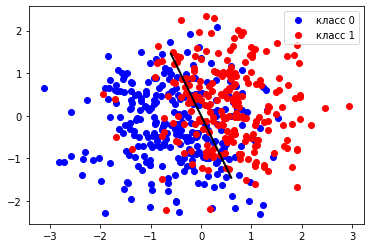

In [29]:
cols = ['blue', 'red']

for k in np.unique(Y_test):
    plt.plot(X_test[Y_test==k,0], X_test[Y_test==k,1], 'o', 
             label='класс {}'.format(k), color=cols[k])

plt.plot(*get_line(*model.coef_[0], x_min=-0.6, x_max=0.6), 
         linewidth=2, color='black')

plt.legend(loc='best')
plt.show()

## Автоматическое дифференцирование

### Разбор примера

Рассмотрим на примере:
$$
f\bigr(\mathbf{x}\bigr) = x_3\cdot\cos\bigr(\frac{x_1}{x_2}\bigr)\cdot\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)
$$


#### Граф вычислений
$$
f\bigr(\mathbf{x}\bigr) = x_3\cdot\cos\bigr(\frac{x_1}{x_2}\bigr)\cdot\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)
$$
![](https://github.com/kalkolab/VorontsovMachineLearningSeminars/blob/master/sem3/fig1.png?raw=1)

$$
f\bigr(\mathbf{x}\bigr) = x_3\cdot\cos\bigr(\frac{x_1}{x_2}\bigr)\cdot\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)
$$

#### Дифференцирование вперед
- $\frac{\partial z_1}{\partial x_1} = \frac{1}{x_2}$
- $\frac{\partial z_2}{\partial x_1} = 0$
- $\frac{\partial z_3}{\partial x_1} = \frac{\partial z_3}{\partial z_1}\frac{\partial z_1}{\partial x_1} = -\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}$
- $\frac{\partial z_4}{\partial x_1} = \frac{\partial z_4}{\partial z_1}\frac{\partial z_1}{\partial x_1} + \frac{\partial z_4}{\partial z_2}\frac{\partial z_2}{\partial x_1} = \frac{1}{x_2}$
- $\frac{\partial z_5}{\partial x_1} = \frac{\partial z_5}{\partial z_3}\frac{\partial z_3}{\partial x_1} + \frac{\partial z_5}{\partial z_4}\frac{\partial z_4}{\partial x_1} = -\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) +\cos\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}$
- $\frac{\partial z_6}{\partial x_1} = \frac{\partial z_6}{\partial z_5}\frac{\partial z_5}{\partial x_1} + \frac{\partial z_6}{\partial x_3}\frac{\partial x_3}{\partial x_1} = x_3\left(-\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) +\cos\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\right)$
- $\frac{\partial f}{x_1}= \frac{\partial f}{\partial x_1}\frac{\partial z_6}{\partial x_1} = x_3\left(-\sin\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) +\cos\bigr(\frac{x_1}{x_2}\bigr)\frac{1}{x_2}\right)$

$$
f\bigr(\mathbf{x}\bigr) = x_3\cdot\cos\bigr(\frac{x_1}{x_2}\bigr)\cdot\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)
$$

#### Дифференцирование назад
- $\frac{\partial f}{\partial z_6} = 1$
- $\frac{\partial f}{\partial z_5} = \frac{\partial f}{\partial z_6}\frac{\partial z_6}{\partial z_5} = x_3$
- $\frac{\partial f}{\partial z_4} = \frac{\partial f}{\partial z_5}\frac{\partial z_5}{\partial z_4} = x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$
- $\frac{\partial f}{\partial z_3} = \frac{\partial f}{\partial z_5}\frac{\partial z_5}{\partial z_3} = x_3\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right)$
- $\frac{\partial f}{\partial z_2} = \frac{\partial f}{\partial z_4}\frac{\partial z_4}{\partial z_2} = x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$
- $\frac{\partial f}{\partial z_1} = \frac{\partial f}{\partial z_3}\frac{\partial z_3}{\partial z_1} + \frac{\partial f}{\partial z_4}\frac{\partial z_4}{\partial z_1} = -\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) -\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$
- $\frac{\partial f}{\partial x_1} = \frac{\partial f}{\partial z_1}\frac{\partial z_1}{\partial x_1} = -\frac{1}{x_2}\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\left(\exp\bigr(x_3\bigr)+ \frac{x_1}{x_2}\right) -\frac{1}{x_2}\sin\bigr(\frac{x_1}{x_2}\bigr)x_3\cos\bigr(\frac{x_1}{x_2}\bigr)$


### Плюсы и минусы каждого метода
Дифференцирование вперед:
- использует меньше памяти чем дифференцирование назад;
- вычислительная сложность зависит от числа параметров.

Дифференцирование назад:
- использует больше памяти чем дифференцирование вперед;
- вычислительная сложность не зависит от числа параметров.

## MNIST Dataset

In [30]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

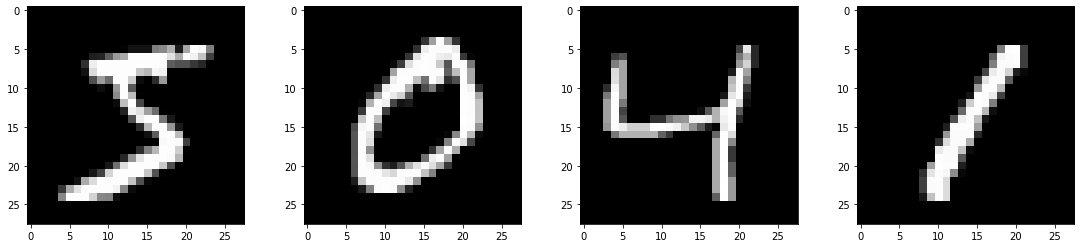

In [31]:
fig, gs = plt.figure(figsize=(19,4)), gridspec.GridSpec(1, 4)

ax = []

for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(MNIST_train[i][0][0]), 'gray')

plt.show()

### Полносвязная нейронная сеть (Персептрон)
![](https://github.com/kalkolab/VorontsovMachineLearningSeminars/blob/master/sem3/fig2.png?raw=1)

Перепишем в матричном виде:
$$
f(\mathbf{x}, \mathbf{W}) = \mathbf{W}_{n_2+1}\sigma\bigr( \cdots\mathbf{W}_2\sigma\bigr(\mathbf{W}_{1}\mathbf{x}\bigr)\cdots\bigr)
$$

В данном примере введены следующие обозначения:
- число $n$ --- размерность пространства признаков (`input_dim`);
- число $n_1$ --- размерность скрытого слоя (`hidden_dim`);
- число $n_2$ --- количество скрытых слоев (`num_layers`);
- число $n_3$ --- размерность пространства ответов (`output_dim`).

Заметим, что при $n_2=0$ получаем линейную модель, то есть линейная модель это частный случай полносвязного персептрона.

P.S. размерность скрытого слоя может зависить от номера слоя, для простоты рассмотрим фиксируемый размер скрытого слоя.

In [32]:
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim=784, num_layers=0, 
                 hidden_dim=64, output_dim=10, p=0.0, device='cpu'):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        self.to(device)
        
    def forward(self, input):
        return self.layers(input)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [34]:
model = Perceptron(device=device)
model

Perceptron(
  (layers): Sequential(
    (classifier): Linear(in_features=784, out_features=10, bias=True)
  )
)

In [35]:
model = Perceptron(num_layers=1, device=device)
model

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [36]:
model = Perceptron(num_layers=2, device=device)
model

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [37]:
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)

    pred = []
    real = []
    for x, y in tqdm(generator, leave=False):
        x = x.view([-1, 784]).to(device)
        y = y.to(device)

        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())

    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)

In [38]:
def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64, 
                                              shuffle=True)
        for x, y in tqdm(generator, leave=False):
            optimizer.zero_grad()
            x = x.view([-1, 784]).to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()

In [39]:
def draw_table(data, title=['ACCURACY'], width=[60, 15]):    
    row_format = '|' + '|'.join([("{:>"+str(w)+"}") for w in width]) + '|'
    row_format_bet = '+' + '+'.join([("{:>"+str(w)+"}") for w in width]) + '+'
    
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    print(row_format.format("", *title))
    print(row_format_bet.format(
        "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))
    for key in data:
        if len(key) > width[0]:
            row_name = '...' + key[len(key)-width[0]+3:]
        else:
            row_name = key
        print(row_format.format(row_name, *[round(x, 2) for x in data[key]]))
        print(row_format_bet.format(
            "-"*width[0], *["-"*width[i+1] for i, _ in enumerate(title)]))

In [40]:
model = Perceptron(num_layers=0, device=device)

In [41]:
_ = model.eval()
acc, report = testing(model, MNIST_test)
print(report)

              precision    recall  f1-score   support

           0       0.05      0.04      0.05       980
           1       0.03      0.06      0.04      1135
           2       0.00      0.00      0.00      1032
           3       0.01      0.01      0.01      1010
           4       0.04      0.01      0.02       982
           5       0.11      0.08      0.09       892
           6       0.01      0.00      0.00       958
           7       0.21      0.51      0.29      1028
           8       0.09      0.03      0.05       974
           9       0.10      0.23      0.14      1009

    accuracy                           0.10     10000
   macro avg       0.06      0.10      0.07     10000
weighted avg       0.06      0.10      0.07     10000



In [43]:
_ = model.train()
trainer(model=model, 
        dataset=MNIST_train, 
        loss_function=torch.nn.CrossEntropyLoss(), 
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=10)

In [44]:
_ = model.eval()
acc, report = testing(model, MNIST_test)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.92      1032
           3       0.91      0.91      0.91      1010
           4       0.94      0.93      0.94       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.91      0.93      1028
           8       0.88      0.89      0.89       974
           9       0.89      0.93      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



#### Гиперпараметры, которые нужно подобрать
- num_layers
- hidden_dim
- lr
- p

Воспользуемся Cross Validation для их подбора.

In [45]:
cross_val = KFold(3)
number_of_batch = cross_val.get_n_splits(MNIST_train)

grid = ParameterGrid({'num_layers': [0, 2], 
                      'hidden_dim': [8, 64],
                      'p': [0.3, 0.7],
                      'lr': [0.001]})

X_train = MNIST_train.transform(MNIST_train.data.numpy()).transpose(0,1)
Y_train = MNIST_train.targets.data

In [46]:
scores = dict()
for item in tqdm(grid):
    list_of_scores = []
    for train_index, test_index in tqdm(cross_val.split(X_train), 
                                        total=number_of_batch, leave=False):
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]

        traindata = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        testdata = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)


        model = Perceptron(num_layers=item['num_layers'], p=item['p'],
                           hidden_dim=item['hidden_dim'], device=device)
        _ = model.train()
        trainer(model=model, 
                dataset=traindata, 
                loss_function=torch.nn.CrossEntropyLoss(), 
                optimizer=torch.optim.Adam(model.parameters(), lr=item['lr']), 
                epochs=4)
        
        _ = model.eval()
        acc, report = testing(model, testdata)
        list_of_scores.append(acc)
    scores[str(item)] = [np.mean(list_of_scores)]
                

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
draw_table(scores)

+------------------------------------------------------------+---------------+
|                                                            |       ACCURACY|
+------------------------------------------------------------+---------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}|           0.92|
+------------------------------------------------------------+---------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.7}|           0.92|
+------------------------------------------------------------+---------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.3}|           0.84|
+------------------------------------------------------------+---------------+
|   {'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.7}|            0.5|
+------------------------------------------------------------+---------------+
|  {'hidden_dim': 64, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}|           0.92|
+---------------------------------------------------

## Прореживание нейросетей

![](https://github.com/kalkolab/VorontsovMachineLearningSeminars/blob/master/sem3/fig3.png?raw=1)

1 - Произвольное удаление параметров 2 - Optimal Brain Damage
3 - Variational Method               4 - Удаление зависимых признаков

![](https://github.com/kalkolab/VorontsovMachineLearningSeminars/blob/master/sem3/fig4.png?raw=1)

1 - Произвольное удаление параметров 2 - Optimal Brain Damage
3 - Variational Method               4 - Удаление зависимых признаков

### То же самое с помощью TF

In [48]:
import tensorflow as tf

In [54]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [94]:
class Perceptron(tf.Module):
    def __init__(self, input_dim=784, num_layers=0, 
                 hidden_dim=64, output_dim=10, p=0.0, device='cpu'):
        super(Perceptron, self).__init__()
        
        self.layers = tf.keras.models.Sequential()
        
        self.layers.add(tf.keras.layers.Flatten(input_shape=(28,28), name='Flatten'))
        for i in range(num_layers):
            self.layers.add(tf.keras.layers.Dense(hidden_dim, activation='relu', name=f'Dense_{i}'))
            self.layers.add(tf.keras.layers.Dropout(p, name=f'Dropout_{i}'))
        
        self.layers.add(tf.keras.layers.Dense(output_dim, name='Output'))        
        
    def forward(self, input):
        # for layer in self.layers:
        #   input = layer(input)
        # return input
        return self.layers(input)
    
    def __call__(self, input):
        return self.forward(input)

In [134]:
model = Perceptron(num_layers=1)
model.layers.compile(optimizer='adam', 
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                     metrics=['accuracy'])

In [135]:
model.layers.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
Dense_0 (Dense)              (None, 64)                50240     
_________________________________________________________________
Dropout_0 (Dropout)          (None, 64)                0         
_________________________________________________________________
Output (Dense)               (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [136]:
model(x_test[:1]).numpy()

array([[ 0.5423504 ,  0.14452013,  0.36186075, -0.6598077 , -0.43178096,
        -0.04573351,  0.16098875, -0.09286813, -0.12324471, -0.11211281]],
      dtype=float32)

In [137]:
model.layers.fit(x_train, y_train, epochs=4)

Epoch 1/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5116 - accuracy: 0.8520
Epoch 2/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1572 - accuracy: 0.9535
Epoch 3/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1141 - accuracy: 0.9658
Epoch 4/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0860 - accuracy: 0.9745


In [140]:
model.layers.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.1040 - accuracy: 0.9685


[0.10403228551149368, 0.968500018119812]